## HMMs and Viterbi algorithm for POS tagging


* In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

* Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.
Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?
 

* You have been given a 'test' file below containing some sample sentences with unknown words. Look at the sentences and try to observe rules which may be useful to tag unknown words. Your final model will be evaluated on a similar test file.

#### Data Preparation

In [48]:
#Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, nltk,time,pprint,random, requests
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split


In [50]:
#downloading treebank and universal_tagset
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\home\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\home\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [51]:
#Reading the treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [61]:
#Reading the input file to copy the text in a variable for further processing
input_file = open("Test_sentences.txt","r")
text=input_file.readlines()
input_file.close()
print(text)

['Android is a mobile operating system developed by Google.\n', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n', 'Show me the cheapest round trips from Dallas to Atlanta\n', 'I would like to see flights from Denver to Philadelphia.\n', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n', 'NASA invited social media users to

In [62]:
#replacing the newline characters to blank and doing word tokenization
text=[word_tokenize(newline.replace("\n","")) for newline in text]
#text

In [149]:
# Converting the Sample Test File into a List
SampleUntaggedWords=[word for sent in text for word in sent]
#SampleUntaggedWords

In [64]:
#Checking the length of treebank tagged sentences
len(nltk_data)

3914

In [150]:
#Splitting data into train set & test set
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)
#print(len(train_set))
#print(len(test_set))
#print(train_set[:40])

In [66]:
#Fetching the list of  tagged words 
train_tagged_words=[tup for sent in train_set for tup in sent]
len(train_tagged_words)

95665

In [67]:
#Fetching list of tokens tagged in nltk_data Set
tokens = [x[0] for x in train_tagged_words]

In [119]:
#Fetching the vocabulary in train set
Vocab = set(tokens)
#Checking the length of the vocab
len(Vocab)

12089

In [120]:
#fetching the list of tags in train set
Tags=[x[1] for x in train_tagged_words]
TagCounts=Counter(Tags)
UniqueTags=set(Tags)


In [121]:
print(len(Tags))
print(len(UniqueTags))
print(TagCounts.most_common(12))
print("Most common tag:", TagCounts.most_common(12)[0][0])

95665
12
[('NOUN', 27408), ('VERB', 12895), ('.', 11153), ('ADP', 9355), ('DET', 8284), ('X', 6296), ('ADJ', 6071), ('NUM', 3387), ('PRT', 3036), ('ADV', 3018), ('PRON', 2589), ('CONJ', 2173)]
Most common tag: NOUN


#### Emission Probability

In [71]:
#computing the word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0].lower()==word.lower()]
    count_w_given_tag = len(w_given_tag_list)
    EmissionProbability = count_w_given_tag/count_tag
    return (count_w_given_tag, count_tag,EmissionProbability)

#### Transition Probability

In [122]:
# computing tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    TransitionProbability=count_t2_t1/count_t1
    return (count_t2_t1, count_t1,TransitionProbability)

In [123]:
#creating transition matrix of the tags
tags_matrix = np.zeros((len(UniqueTags), len(UniqueTags)), dtype='float32')
for i, t1 in enumerate(list(UniqueTags)):
    for j, t2 in enumerate(list(UniqueTags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[2]

In [124]:
#creating dataframe for it for processing next
df_tags= pd.DataFrame(tags_matrix,columns=list(UniqueTags), index=list(UniqueTags))

In [125]:
df_tags

,NOUN,VERB,PRON,ADP,ADV,ADJ,NUM,.,PRT,X,CONJ,DET
NOUN,0.264302,0.146600,0.004561,0.176153,0.016966,0.012332,0.009340,0.241462,0.043272,0.028824,0.043126,0.013062
VERB,0.109965,0.168748,0.035595,0.092206,0.082202,0.065064,0.022644,0.034665,0.031485,0.217604,0.005584,0.134238
PRON,0.208961,0.483971,0.007725,0.023947,0.033990,0.073774,0.007725,0.039784,0.012360,0.093086,0.005021,0.009656
ADP,0.322074,0.008338,0.068520,0.017424,0.013683,0.106895,0.062961,0.039872,0.001497,0.035168,0.000855,0.322715
ADV,0.030815,0.347581,0.014911,0.120278,0.082174,0.127568,0.030152,0.134195,0.013254,0.023194,0.006958,0.068920
ADJ,0.700379,0.012189,0.000659,0.077088,0.004942,0.065722,0.020425,0.065722,0.010212,0.020754,0.016966,0.004942
NUM,0.350458,0.018010,0.001476,0.033953,0.002657,0.033658,0.186596,0.116032,0.028048,0.211692,0.014172,0.003248
.,0.223438,0.088676,0.065543,0.090200,0.051287,0.044383,0.081772,0.092710,0.002331,0.027795,0.058191,0.173586
PRT,0.244401,0.403162,0.019104,0.019104,0.009552,0.083333,0.058300,0.042819,0.001976,0.013834,0.001976,0.102437
X,0.062421,0.206321,0.054638,0.144695,0.026048,0.016677,0.002541,0.163437,0.183609,0.073856,0.010483,0.055273


In [126]:
df_tags.loc['.', :]

NOUN    0.223438
VERB    0.088676
PRON    0.065543
ADP     0.090200
ADV     0.051287
ADJ     0.044383
NUM     0.081772
.       0.092710
PRT     0.002331
X       0.027795
CONJ    0.058191
DET     0.173586
Name: ., dtype: float32

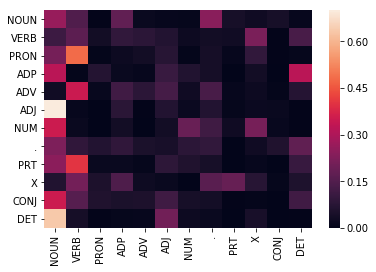

In [127]:
#Checking the heatmap of tags matrix
#T(i, j) means P(tag j given tag i)
plt.figure(figsize=(6, 4))
sns.heatmap(df_tags)
plt.show()

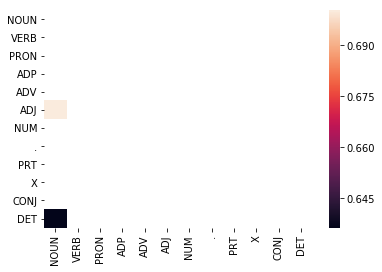

In [128]:
#frequent tags
#filter the df to get P(t2, t1) > 0.5
tags_frequent = df_tags[df_tags>0.5]
plt.figure(figsize=(6, 4))
sns.heatmap(tags_frequent)
plt.show()

#### Building Vanilla Viterbi based POS tagger

In [129]:
len(train_tagged_words)

95665

In [130]:
#Defining Viterbi Heuristic Function
def Viterbi(words, train_bag = train_tagged_words, tag_matrix=df_tags):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tag_matrix.loc['.', tag]
            else:
                transition_p = tag_matrix.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[2]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [151]:
# As running the entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
#test_run

In [132]:
#Tagging the test sentences through Vanilla Viterbi Algorithm
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [133]:
print("Total time taken in seconds:", difference)
print(tagged_seq[:5])

Total time taken in seconds: 20.161108255386353
[('And', 'CONJ'), ('my', 'PRON'), ('newspaper', 'NOUN'), ('can', 'VERB'), ('print', 'VERB')]


In [134]:
#checking the accuracy of Vanilla Viterbi Algorithm
check=[i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [98]:
accuracy=len(check)/len(tagged_seq)

In [99]:
accuracy

0.9622641509433962

In [100]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [101]:
incorrect_tagged_cases

[[('those', 'DET'), (('broadcasts', 'VERB'), ('broadcasts', 'NOUN'))],
 [('$', '.'), (('2.47', 'NOUN'), ('2.47', 'NUM'))],
 [('up', 'ADV'), (('7.4', 'NOUN'), ('7.4', 'NUM'))],
 [('$', '.'), (('2.30', 'NOUN'), ('2.30', 'NUM'))]]

In [135]:
#Tagging the sample file with Vanila viterbi Function 
start=time.time()
sample_tagged_seq=Viterbi(SampleUntaggedWords)
end=time.time()
difference=end-start
print("Time taken in seconds: ", difference)
print(sample_tagged_seq)

Time taken in seconds:  34.27239489555359
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service'

#### Now Let's solve the problem for unknown words

#### First Method
* Regular Expression based tagging for unknown words.

In [103]:
## Call the function for both train-test set and sample sentence provided and calculate accuracy before and after.
    
"""
Various patterns defined for recognizing the words that are not present in the vocabulary
"""
patterns = [
    (r'.*ing$', 'VERB'),               # gerunds
    (r'.*ed$', 'VERB'),                # simple past
    (r'.*es$', 'VERB'),                # 3rd singular present
    (r'.*ould$', 'VERB'),               # modals
    (r'.*\'s$', 'NOUN'),               # possessive nouns
    (r'.*s$', 'NOUN'),                 # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),  # numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles 
    (r'.*able$', 'ADJ'),                # adjectives 
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'(He|he|She|she|It|it|I|me|Me|You|you)$', 'PRON'), # pronouns
    (r'(His|his|Her|her|Its|its)$', 'PRON'),    # possesive
    (r'(my|Your|your|Yours|yours)$', 'PRON'),   # possesive
    (r'(on|On|in|In|at|At|since|Since)$', 'ADP'),# time prepopsitions
    (r'(for|For|ago|Ago|before|Before)$', 'ADP'),# time prepopsitions
    (r'(till|Till|until|Until)$', 'ADP'),        # time prepopsitions
    (r'(by|By|beside|Beside)$', 'ADP'),          # space prepopsitions
    (r'(under|Under|below|Below)$', 'ADP'),      # space prepopsitions
    (r'(over|Over|above|Above)$', 'ADP'),        # space prepopsitions
    (r'(across|Across|through|Through)$', 'ADP'),# space prepopsitions
    (r'(into|Into|towards|Towards)$', 'ADP'),    # space prepopsitions
    (r'(onto|Onto|from|From)$', 'ADP'),          # space prepopsitions    
    (r'[0-9]+\-[0-9]+', 'NUM'),                      # Number     
    (r'^\*', 'X'),                        
    (r'.*', 'NOUN')                      # nouns (default) as the maximum number of words are assigned Nouns
    ]

In [104]:
# Viterbi Heuristic Function based on on Regex Patterns
def Viterbi_with_Regex_Patterns(words, RegexPattern=patterns, train_bag = train_tagged_words, tag_matrix=df_tags):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    Vocab=list(set(pair[0] for pair in train_bag))
    regexp_tagger = nltk.RegexpTagger(RegexPattern)

    for key, word in enumerate(words):
        if (words[key] in Vocab):
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tag_matrix.loc['.', tag]
                else:
                    transition_p = tag_matrix.loc[state[-1], tag]
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[2]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            Derived_Tag=regexp_tagger.tag([words[key]])[0][1]
            state.append(Derived_Tag)
    return list(zip(words, state))

In [105]:
start = time.time()
tagged_seq_technique1 = Viterbi_with_Regex_Patterns(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_technique1[:50])

Time taken in seconds:  24.266274452209473
[('And', 'CONJ'), ('my', 'PRON'), ('newspaper', 'NOUN'), ('can', 'VERB'), ('print', 'VERB'), ('the', 'DET'), ('text', 'NOUN'), ('of', 'ADP'), ('those', 'DET'), ('broadcasts', 'VERB'), ('.', '.'), ('He', 'PRON'), ('is', 'VERB'), ('his', 'PRON'), ('own', 'ADJ'), ('man', 'NOUN'), ('.', '.'), ('Each', 'DET'), ('50,000', 'NUM'), ('Swiss', 'ADJ'), ('franc', 'NOUN'), ('note', 'NOUN'), ('is', 'VERB'), ('convertible', 'ADJ'), ('from', 'ADP'), ('Nov.', 'NOUN'), ('30', 'NUM'), (',', '.'), ('1989', 'NUM'), (',', '.'), ('to', 'PRT'), ('March', 'NOUN'), ('16', 'NUM'), (',', '.'), ('1994', 'NUM'), ('at', 'ADP'), ('a', 'DET'), ('5', 'NUM'), ('%', 'NOUN'), ('premium', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('closing', 'ADJ'), ('share', 'NOUN'), ('price', 'NOUN'), ('Monday', 'NOUN'), (',', '.'), ('when', 'ADV'), ('terms', 'NOUN'), ('are', 'VERB')]


In [106]:
check_technique1 = [i for i, j in zip(tagged_seq_technique1, test_run_base) if i == j] 
accuracy_technique1 = len(check_technique1)/len(tagged_seq)
accuracy_technique1

0.9905660377358491

In [107]:
# Tagging the Sample File with the Viterbi Function Technique I - 
# implementing Regex function for the unknown words

start=time.time()
sample_tagged_seq_technique_1=Viterbi_with_Regex_Patterns(SampleUntaggedWords)
end=time.time()
difference=end-start
print("Time taken in seconds: ", difference)
print(sample_tagged_seq_technique_1)

Time taken in seconds:  39.5842924118042
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'VERB'), ('service', 'N

#### Second method
* Probablistic approach, based on the previous Tag / Transitional Probability

In [136]:
#defining Viterbi_with_TransitionPobability function
def Viterbi_with_TransitionPobability(words, RegexPattern=patterns, train_bag = train_tagged_words, tag_matrix=df_tags):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    Vocab=list(set(pair[0] for pair in train_bag))

    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tag_matrix.loc['.', tag]
            else:
                transition_p = tag_matrix.loc[state[-1], tag]
            # compute emission and state probabilities
            if (words[key] in Vocab):
                emission_p = word_given_tag(words[key], tag)[2]
            else:
                emission_p=1
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [138]:
start = time.time()
tagged_seq_technique2= Viterbi_with_TransitionPobability(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq_technique2[:50])

Time taken in seconds:  19.270174264907837
[('And', 'CONJ'), ('my', 'PRON'), ('newspaper', 'NOUN'), ('can', 'VERB'), ('print', 'VERB'), ('the', 'DET'), ('text', 'NOUN'), ('of', 'ADP'), ('those', 'DET'), ('broadcasts', 'VERB'), ('.', '.'), ('He', 'PRON'), ('is', 'VERB'), ('his', 'PRON'), ('own', 'ADJ'), ('man', 'NOUN'), ('.', '.'), ('Each', 'DET'), ('50,000', 'NUM'), ('Swiss', 'ADJ'), ('franc', 'NOUN'), ('note', 'NOUN'), ('is', 'VERB'), ('convertible', 'ADJ'), ('from', 'ADP'), ('Nov.', 'NOUN'), ('30', 'NUM'), (',', '.'), ('1989', 'NUM'), (',', '.'), ('to', 'PRT'), ('March', 'NOUN'), ('16', 'NUM'), (',', '.'), ('1994', 'NUM'), ('at', 'ADP'), ('a', 'DET'), ('5', 'NUM'), ('%', 'NOUN'), ('premium', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('closing', 'ADJ'), ('share', 'NOUN'), ('price', 'NOUN'), ('Monday', 'NOUN'), (',', '.'), ('when', 'ADV'), ('terms', 'NOUN'), ('are', 'VERB')]


In [139]:
check_technique2 = [i for i, j in zip(tagged_seq_technique2, test_run_base) if i == j] 
accuracy_technique2 = len(check_technique2)/len(tagged_seq)
accuracy_technique2

0.9622641509433962

In [140]:
#Tagging the Sample File with the Viterbi Function Technique II
#implementing tagging based on the transition probability in case word is not in vocabulary
start=time.time()
sample_tagged_seq_technique_2=Viterbi_with_TransitionPobability(SampleUntaggedWords)
end=time.time()
difference=end-start
print("Time taken in seconds: ", difference)
print(sample_tagged_seq_technique_2)

Time taken in seconds:  27.11252999305725
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'

#### Evauating the accuracy for three methods(Vanilla,Regex,Probablistic)

In [141]:
(accuracy, accuracy_technique1, accuracy_technique2)

(0.9622641509433962, 0.9905660377358491, 0.9622641509433962)

In [144]:
#Incorrect tagged cases obtained with the vanila Viterbi Function
print("Length of incorrect Tags:", len(incorrect_tagged_cases))
incorrect_tagged_cases

Length of incorrect Tags: 4


[[('those', 'DET'), (('broadcasts', 'VERB'), ('broadcasts', 'NOUN'))],
 [('$', '.'), (('2.47', 'NOUN'), ('2.47', 'NUM'))],
 [('up', 'ADV'), (('7.4', 'NOUN'), ('7.4', 'NUM'))],
 [('$', '.'), (('2.30', 'NOUN'), ('2.30', 'NUM'))]]

In [145]:
#Incorrect tagged cases obtained with the Viterbi Function using the Regex Pattern 
incorrect_tagged_cases_technique_1 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_technique1, test_run_base)) if j[0]!=j[1]]
print("Length of incorrect Tags:", len(incorrect_tagged_cases_technique_1))
incorrect_tagged_cases_technique_1

Length of incorrect Tags: 1


[[('those', 'DET'), (('broadcasts', 'VERB'), ('broadcasts', 'NOUN'))]]

In [146]:
#Incorrect tagged cases obtained with the Viterbi Function using transition probability in case of unknown words
incorrect_tagged_cases_technique_2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_technique2, test_run_base)) if j[0]!=j[1]]
print("Length of incorrect Tags : ", len(incorrect_tagged_cases_technique_2))
incorrect_tagged_cases_technique_2

Length of incorrect Tags :  4


[[('those', 'DET'), (('broadcasts', 'VERB'), ('broadcasts', 'NOUN'))],
 [('$', '.'), (('2.47', 'NOUN'), ('2.47', 'NUM'))],
 [('up', 'ADV'), (('7.4', 'VERB'), ('7.4', 'NUM'))],
 [('$', '.'), (('2.30', 'NOUN'), ('2.30', 'NUM'))]]

In [147]:
#Comparison of the Tagging done by Vanilla Approach and modified Approach on Sample File. 
Sample_Tagged_Comparison_List = list(zip(sample_tagged_seq,sample_tagged_seq_technique_1,sample_tagged_seq_technique_2))
Sample_Tagged_Comparison_List

[(('Android', 'NOUN'), ('Android', 'NOUN'), ('Android', 'NOUN')),
 (('is', 'VERB'), ('is', 'VERB'), ('is', 'VERB')),
 (('a', 'DET'), ('a', 'DET'), ('a', 'DET')),
 (('mobile', 'ADJ'), ('mobile', 'ADJ'), ('mobile', 'ADJ')),
 (('operating', 'NOUN'), ('operating', 'NOUN'), ('operating', 'NOUN')),
 (('system', 'NOUN'), ('system', 'NOUN'), ('system', 'NOUN')),
 (('developed', 'VERB'), ('developed', 'VERB'), ('developed', 'VERB')),
 (('by', 'ADP'), ('by', 'ADP'), ('by', 'ADP')),
 (('Google', 'NOUN'), ('Google', 'NOUN'), ('Google', 'DET')),
 (('.', '.'), ('.', '.'), ('.', '.')),
 (('Android', 'NOUN'), ('Android', 'NOUN'), ('Android', 'NOUN')),
 (('has', 'VERB'), ('has', 'VERB'), ('has', 'VERB')),
 (('been', 'VERB'), ('been', 'VERB'), ('been', 'VERB')),
 (('the', 'DET'), ('the', 'DET'), ('the', 'DET')),
 (('best-selling', 'ADJ'), ('best-selling', 'ADJ'), ('best-selling', 'ADJ')),
 (('OS', 'NOUN'), ('OS', 'NOUN'), ('OS', 'NOUN')),
 (('worldwide', 'NOUN'), ('worldwide', 'NOUN'), ('worldwide', 'NO

#### From  above list we can conclude that numbers are handled well by the modified algo whereas the Vanilla Vetibri has failed to handle the same.

#### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [148]:
Differences =[x for x in Sample_Tagged_Comparison_List if (x[0]!=x[1]) | (x[0]!=x[2]) | (x[1]!=x[2])]
Differences

[(('Google', 'NOUN'), ('Google', 'NOUN'), ('Google', 'DET')),
 (('smartphones', 'NOUN'), ('smartphones', 'VERB'), ('smartphones', 'DET')),
 (('2011', 'NOUN'), ('2011', 'NUM'), ('2011', 'DET')),
 (('2013', 'NOUN'), ('2013', 'NUM'), ('2013', 'DET')),
 (('2015', 'NOUN'), ('2015', 'NUM'), ('2015', 'DET')),
 (('Google', 'NOUN'), ('Google', 'NOUN'), ('Google', 'X')),
 (('Twitter', 'NOUN'), ('Twitter', 'NOUN'), ('Twitter', 'VERB')),
 (('firehose', 'NOUN'), ('firehose', 'NOUN'), ('firehose', 'VERB')),
 (('networking', 'NOUN'), ('networking', 'VERB'), ('networking', 'NOUN')),
 (('messages', 'NOUN'), ('messages', 'VERB'), ('messages', 'DET')),
 (('tweets', 'NOUN'), ('tweets', 'NOUN'), ('tweets', 'DET')),
 (('domineering', 'NOUN'), ('domineering', 'VERB'), ('domineering', 'NOUN')),
 (('2018', 'NOUN'), ('2018', 'NUM'), ('2018', 'NOUN')),
 (('contested', 'NOUN'), ('contested', 'VERB'), ('contested', 'NOUN')),
 (('arriving', 'NOUN'), ('arriving', 'VERB'), ('arriving', 'NOUN')),
 (('invited', 'NOUN')

#### Cases which were incorrectly predicted but got correct by the modified Vanila Algorithm are :-

* Number was incorrectly predicted by the Vanilla algorithm which was corrected by the modified Algorithm
* Words like  tournament was incorrectly predicted  by Vanilla Algorithm which was later on corrected by Modified Algorithm.
* Words like NASA was incorrectly predicted  by Vanilla Algorithm was later on corrected as by modified Algorithm.